# Part 2: Handling the Cold Start Problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

## Step 1: Import the Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Step 2: Load the Data

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

Let's take a peak at our `movies` dataframe.

In [4]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


## Step 3: Data Cleaning

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [5]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"


#### Cleaning up the `title` column

Our second data cleaning task is to clean up the title column by removing the year. Let's do this by first creating a function that can clean a single 'title' string, then apply it to the entire dataframe using pandas' apply method.

In [6]:
title = movies['title'][0]

print(title)

def get_title(title):
    t = title.split(' ')
    t.pop()
    t = ' '.join(t)
    return t

get_title(title)

Toy Story (1995)


'Toy Story'

In [7]:
def get_year(title):
    t = title.split(' ')
    year = t.pop()
    year = year.strip('()')
    return year

get_year(title)

'1995'

We can use the `apply` method to apply our functions `get_title()` and `get_year()` to the `title` column of our dataframe.

In [8]:
movies['year'] = movies['title'].apply(get_year)
movies['title'] = movies['title'].apply(get_title)

We now have a nice, clean dataframe with proper title and year columns. Let's take a peak at the first couple of rows.

In [9]:
movies.head(2)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995


## Step 4: Exploratory Data Analysis

#### A Glimpse at Movie Genres

In [10]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [11]:
genre_df = pd.DataFrame.from_dict(genre_frequency, orient='index').reset_index()
genre_df.columns = ['genre', 'count']

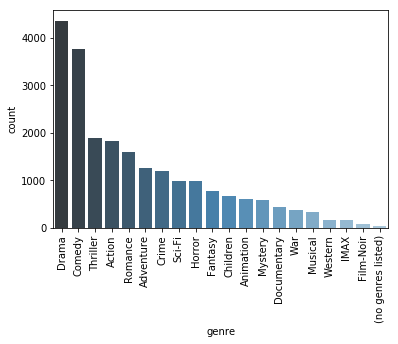

In [12]:
sns.barplot(x='genre', y='count', data=genre_df.sort_values(by='count', ascending=False), palette='Blues_d')
plt.xticks(rotation=90)
plt.show()

#### Year of Release

In [13]:
years = map(str, np.arange(1980,2018))
year_frequencies = movies[movies['year'].isin(list(years))]['year'].value_counts().reset_index()
year_frequencies.columns = ['year_of_release', 'count']

The `year_of_release` column is currently in string format. We're going to have to convert this column's datatype to integer.

In [14]:
year_frequencies['year_of_release'] = year_frequencies['year_of_release'].astype(int)

Now let's visualize the years of release.

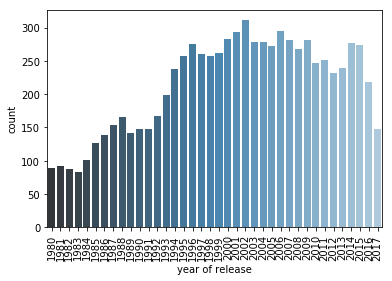

In [15]:
sns.barplot(x='year_of_release', y='count', data=year_frequencies.sort_values(by='year_of_release'), palette='Blues_d')
plt.xticks(rotation=90)
plt.xlabel('year of release')
plt.show()

## Step 5: Data Pre-processing

In [16]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [17]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'year', 'title','genres'])

In [18]:
movie_genres.head()

,Documentary,Drama,Romance,Fantasy,Mystery,Comedy,Adventure,Action,Crime,War,(no genres listed),Animation,Film-Noir,Thriller,IMAX,Horror,Children,Musical,Sci-Fi,Western
0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 6: Item-Item Recommendations using Collaborative Filtering

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# create mapper that maps index to title and vice versa
movie_indices = dict(zip(movies['title'], list(movies.index)))
cosine_sim = cosine_similarity(movie_genres, movie_genres)

print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


The dimensions of our cosine similarity matrix are $M \times M$ where $M$ represents the total number of movies.

In [20]:
title = movies['title'][0]
n_recommendations = 10

idx = movie_indices[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies['title'].iloc[similar_movies]

Recommendations for Toy Story:


1706                                                Antz
2355                                         Toy Story 2
2809             Adventures of Rocky and Bullwinkle, The
3000                           Emperor's New Groove, The
3568                                      Monsters, Inc.
6194                                           Wild, The
6486                                     Shrek the Third
6948                             Tale of Despereaux, The
7760    Asterix and the Vikings (Astérix et les Vikings)
8219                                               Turbo
Name: title, dtype: object

With this approach, we are assuming that two movies are "similar" if they have similar genres. These "similar movie" recommendations are based solely on the metadata from our movies dataset. Feel free to test out different movies.